# Continuous Flow Reaction Optimization Notebook

### Import all packages to use for the model

In [1]:
'''
Steps to get EDBOplus working:
1)Create and activate a conda environment
2)Download and navigate to the edbopaper directory in a terminal window (or Anaconda prompt window) and pip install -r requirements.txt
3)Put this .ipynb file in ANY directory (doesn't matter where it is).
4)Set the path to edbopaper in sys.path.append below
5)...
6)Profit.

'''

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# /mnt/c/Users/sanjay iyer
import os
import shutil
import subprocess
import time


sys.path.append('/home/sanjay/github/Paddy2/Paddy_Manuscript_Repo/rabbitMQ')

## Import EDBO_plus model

In [90]:
#import EDBOplus
sys.path.append('/home/sanjay/github/AFRL/git_edbo/edbopaper/edbo/')
from plus.optimizer_botorch import EDBOplus

## Parameters 

#### Parameters are your input values for the model. Here we will create a range of values for each set of parameters 

In [95]:
#setting up reaction components
#np.arange creates a list of numbers from (start,stop,stepsize)
components = {
              'enzyme_conc':[0,0.25, 0.5,1,2,4,8,16],   # Discrete grid of concentrations
              'substrate_conc': [0,0.125,0.25,0.5,1,2,4,8],
              'incubation_time': [5,15,30,60,120,180,240,480]}

# enzyme_conc = (0,0.25, 0.5,1,2,4,8,16) #nM
# substrate_conc = (0,0.125,0.25,0.5,1,2,4,8) #uM
# incubation_time = (5,15,30,60,120,180,240,480) #min

In [96]:
# need to generage the data scope first
scope = EDBOplus.generate_reaction_scope(components=components)

Generating reaction scope...


## Intialize EDBOplus

#### This cell only needs to be run once at the start. Or if you restart the notebook

In [97]:
#Initialize EDBOplus class that will store predicted means, variances, etc.
bo = EDBOplus()

args = {'objectives': ['assay_optimization_score'], 'objective_mode': ['max'], 'batch': 1, 'seed': 42}


## Run EDBOplus

#### This runs EDBOplus. Run this cell each round after you update the excel spreadsheet with new data.

In [105]:
#Run this cell on scope data (csv file called reaction.csv)
bo.run(**args)

#Timer.sleep to setup a delay 

Using EHVI acquisition function.
Using hyperparameters optimized for continuous variables.
Number of QMC samples: 512
Acquisition function optimized.
Predictions obtained and expected improvement obtained.


,Unnamed: 0,enzyme_conc,substrate_conc,incubation_time,assay_optimization_score,priority
478,478,0.5,0.0,30,PENDING,1.0
511,511,16.0,8.0,480,PENDING,0.0
510,510,0.5,1.0,30,PENDING,0.0
509,509,0.5,1.0,60,PENDING,0.0
508,508,0.5,1.0,120,PENDING,0.0
...,...,...,...,...,...,...
4,4,4.0,0.5,120,PENDING,0.0
3,3,4.0,0.5,180,PENDING,0.0
2,2,4.0,0.5,240,PENDING,0.0
1,1,4.0,0.0,15,PENDING,0.0


Instrument Optimization functions

In [104]:
#create df from reaction csv
df = pd.read_csv('reaction.csv')
aos_global = [0]

#step 1 take in df as input and return optimized parameters for instrument to run
def aos_input(df):
    aos_input = (df['enzyme_conc'][0],df['substrate_conc'][0],df['incubation_time'][0])
    print('aos input ={}'.format(aos_input))
    return aos_input

#Step 2 take in aos_input and calculate AOS   
#update csv
#enzyme_conc, substrate_conc, incubation_time
def assay_optimization_score(aos_input):
    aos = 10000*min(max(0.52-0.495,0),0.025)/((25*df['enzyme_conc'][0]) + (5*df['substrate_conc'][0]) + (df['incubation_time'][0]))
    #z < 0.52 undesirable
    print('aos = {}'.format(aos))
    #time.sleep(1)
    aos_global[0] = aos
    print('global aos = {}'.format(aos_global))
    return aos
#step 3 update results with aos
def results_update():
    print('df before update',df.iloc[[0]])
    df['assay_optimization_score'][0] = float(aos_global[0])
    print('df after update', df.iloc[[0]])
    df.to_csv('reaction.csv', index=False)
    
def run_all():
    aos_input(df)
    assay_optimization_score(aos_input)
    results_update()

run_all()
# aos_input(df)

# results_update()
# df.iloc[[0]]

aos input =(2.0, 4.0, 5)
aos = 3.3333333333333335
global aos = [3.3333333333333335]
df before update    enzyme_conc  substrate_conc  incubation_time assay_optimization_score  \
0          2.0             4.0                5                  PENDING   

   priority  
0         1  
df after update    enzyme_conc  substrate_conc  incubation_time assay_optimization_score  \
0          2.0             4.0                5                 3.333333   

   priority  
0         1  


/home/sanjay/anaconda3/envs/edbo/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Copy data to excel

#### Copies data from the notebook to an excel spreadsheet in a specified folder 

In [12]:
# copy reaction data to folder
# Edit the excel file in this folder and upload back to the edbo folder   
shutil.copyfile('reaction.csv', 'test/reaction.csv')
# shutil.copyfile('reaction.csv', 'test2/reaction.csv')

# /mnt/c/Users/sanja/OneDrive - purdue.edu/Desktop/Purdue/Chopra/Projects/AFRL/edbo_plus/git_edbo/edbopaper/edbo/

'test/reaction.csv'

## Upload excel spreadsheet

#### After you have added the new data into the excel spreadsheet, run this cell to upload the data to the notebook.

In [13]:
#after editing the excel file run this cell
#This will copy the data you updated in your excel sheet to the csv for the model 
shutil.copyfile('test/reaction.csv','reaction.csv')

'reaction.csv'

## Create a dataframe

#### Prepares data to be parsed

In [74]:
#convert csv into df

#df of reaction data
df = pd.read_csv('reaction.csv')
#df of reaction data + predictions
# df2 = pd.read_csv('pred_reaction.csv')


## Parse Data

#### Data is parsed

In [26]:
#convert csv into df

#df of reaction data
df = pd.read_csv('reaction.csv')

#Create a df to plot points 

#turn all pending data to NaN
df = df.replace('PENDING',pd.NaT)
#delete all the NaN data points 
df = df.dropna(axis=0)


#turn data from string to numeric (the pending made them strings)
df['assay_optimiation_score'] = df['assay_optimiation_score'].apply(pd.to_numeric)

#df['round'] = df['round'].apply(pd.to_numeric)
# df = df.sort_values(by='round', ascending=True)

#print(df.iloc[10,6])
#length of results
results_length = []
#loop through all results (-1 means it is a result)
for i in range(len(df['priority']==-1)):
    results_length.append(i)
#max value of yield and production
max_value_aos = df['assay_optimiation_score'].max()
# max_value_production_rate = df['assay_optimiation_score'].max()

# #convert to numpy array for plotting in plotly
# pareto_x = df['assay_optimiation_score'].to_numpy()
# pareto_y =df['assay_optimiation_score'].to_numpy()


,enzyme_conc,substrate_conc,incubation_time,assay_optimiation_score,priority
504,16.00,8.000,480,8,-1.0
505,16.00,8.000,30,11,-1.0
506,16.00,8.000,5,2,-1.0
507,16.00,2.000,480,8,-1.0
508,16.00,0.000,480,6,-1.0
509,8.00,4.000,480,7,-1.0
510,2.00,4.000,5,6,-1.0
511,0.25,0.125,480,14,-1.0


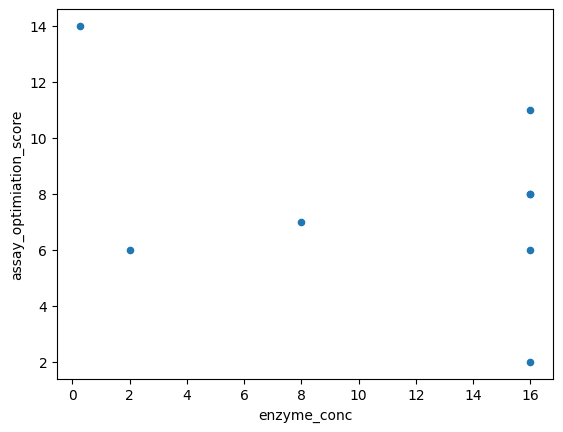

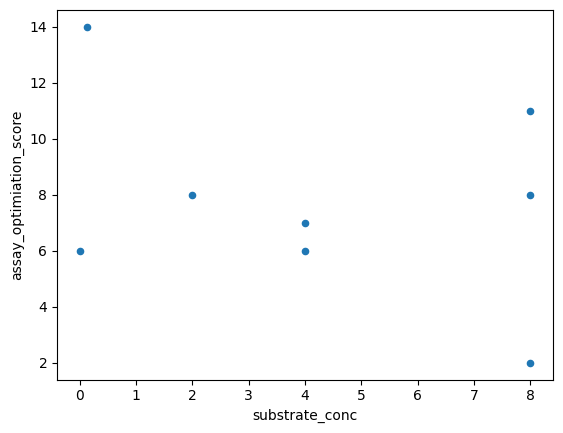

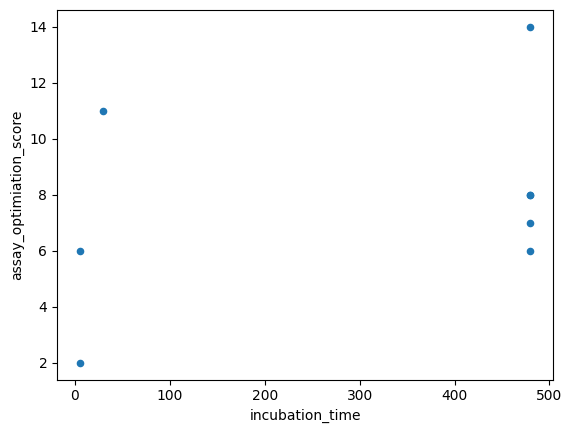

In [41]:
df.plot.scatter('enzyme_conc','assay_optimiation_score')
df.plot.scatter('substrate_conc','assay_optimiation_score')
df.plot.scatter('incubation_time','assay_optimiation_score')


df.head(15)

## Plot Function

#### This is the code for the plot. Run this cell before you run the plot cell.

In [8]:
#plotly scatter plot with pareto front

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]

    fig = px.scatter(df,x='yield', y='production_rate_(g/hr)',
   size='size',
   color='round',
   #animation_frame='round',
    color_discrete_sequence= px.colors.sequential.gray_r,#px.colors.diverging.balance,
     color_continuous_scale=px.colors.sequential.Greys,
    hover_data=['temperature','time','mfp'],
    labels={'yield':'Yield (%)','production_rate_(g/hr)':'Production Rate (g/hr)'})
    fig.add_trace(go.Scatter(x=pf_X, y=pf_Y, name= 'Pareto Front',
                    line=dict(color='firebrick', width=2)))
    fig.update_yaxes(range=[0,3])
    fig.update_xaxes(range=[0,100])
    fig.update_layout(
        title={
            'text': "Multiobjective Optimization of a Continuous Flow Reaction",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            title_y=0.95,
           
            )
    fig.update_traces(marker=dict(line=dict(width=2,color='darkgreen')))
    fig.show()
    print('Highest yield is {}%'.format(df['yield'].max()))
    print('Highest production rate is {}g/hr'.format(df['production_rate_(g/hr)'].max()))
    if not os.path.exists("plots"):
        os.mkdir("plots")
    for i in range(0,20):
        if not os.path.exists("plots/fig{}.png".format(i)):
            fig.write_image("plots/fig{}.png".format(i))
            break
        else:
            print('iteration {} already exists'.format(i))


    

# Plot the data!!

#### Run this cell to visualize the data in a scatter plot. X-axis is the Yield % and the Y-axis is the Production Rate (g/hr). The rounds are color coded. The better the yield, the bigger the data point. The pareto front is plotted with a red line. This shows the predicted parteo front of this multi-objective optimization function. 

In [12]:
#View plots
plot_pareto_frontier(pareto_x, pareto_y)

#Red line is the pareto front
#Colors show the different rounds
#Size based off the yield 

#Ideal optimization is somewhere in the middle (top right) of the pareto front. 

#TODO
# correlation plot (understand how it works)
# 3d plot of inputs  (mostly done)
# PLOTS x-axis round and y axis yield or production rate (mostly done)
# Can you build a model out of it? 


### TO DO
#Make a for loop to print out a plot at each round
#Make a gif of all the images (2 sec delay) (static x and y)


Highest yield is 90.24%
Highest production rate is 2.22g/hr
iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists
iteration 5 already exists
iteration 6 already exists
iteration 7 already exists
iteration 8 already exists
iteration 9 already exists
iteration 10 already exists
iteration 11 already exists
iteration 12 already exists
iteration 13 already exists


In [6]:
fig_3d_animation = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', animation_frame = 'round', color = 'yield', hover_name = 'yield', hover_data = ['yield'])
fig_3d_animation.update_traces(marker=dict(size=7))
fig_3d_animation.update_layout(
scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d_animation.show() 

fig_3d_animation.write_html('plots/3d_plots/final_round/3d_plot_animation.html')

fig_yield_iterations = px.scatter(df,x='round', y='yield',
size='size',
color='round',
color_discrete_sequence= px.colors.sequential.gray_r,#px.colors.diverging.balance,
 color_continuous_scale=px.colors.sequential.Greys,
hover_data=['temperature','time','mfp'],
labels={'yield':'Yield (%)'})
fig_yield_iterations.update_layout(
    title={
        'text': "Yield of Each Iteration for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        
        )
fig_yield_iterations.show()
print('Highest yield is {}%'.format(df['yield'].max()))
    

fig_production_iterations = px.scatter(df,x='round', y='production_rate_(g/hr)',
size='size',
color='round',
color_discrete_sequence= px.colors.sequential.gray_r,#px.colors.diverging.balance,
 color_continuous_scale=px.colors.sequential.Greys,
hover_data=['temperature','time','mfp'],
labels={'production_rate_(g/hr)':'Production Rate (g/hr)'})
fig_production_iterations.update_layout(
    title={
        'text': "Production Rate for Each Iteration for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        
        )
fig_production_iterations.show()
print('Highest production rate is {}g/hr'.format(df['production_rate_(g/hr)'].max()))


Highest yield is 90.24%


Highest production rate is 2.22g/hr


In [5]:
#convert csv into df

#df of reaction data
df = pd.read_csv('reaction.csv')

#Create a df to plot points 

#turn all pending data to NaN
df = df.replace('PENDING',pd.NaT)
#delete all the NaN data points 
df = df.dropna(axis=0)


#turn data from string to numeric (the pending made them strings)
df['production_rate_(g/hr)'] = df['production_rate_(g/hr)'].apply(pd.to_numeric)
df['yield'] = df['yield'].apply(pd.to_numeric)
#df['round'] = df['round'].apply(pd.to_numeric)
df = df.sort_values(by='round', ascending=True)

#print(df.iloc[10,6])
#length of results
results_length = []
#loop through all results (-1 means it is a result)
for i in range(len(df['priority']==-1)):
    results_length.append(i)
#max value of yield and production
max_value_yield = df['yield'].max()
max_value_production_rate = df['production_rate_(g/hr)'].max()

#convert to numpy array for plotting in plotly
pareto_x = df['yield'].to_numpy()
pareto_y =df['production_rate_(g/hr)'].to_numpy()


################################
fig_3d = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'round', hover_name = 'yield', hover_data = ['yield'],color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
fig_3d.update_traces(marker=dict(size=7))
fig_3d.update_layout(
    scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d.show() 

fig_3d.write_html("plots/3d_plots/final_round/3d_final_round.html")
if not os.path.exists("plots/3d_plots/final_round"):
    os.mkdir("plots/3d_plots/final_round")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/final_round/3d_final_round{}.png".format(i)):
        fig_3d.write_image("plots/3d_plots/final_round/3d_final_round{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))


fig_3d_total = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'Round', hover_name = 'yield', hover_data = ['yield'],
)#color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
#fig_3d_total.add_trace((go.Scatter(df,x='temperature', y='time',z='mfp', name= 'Current Round',)))
fig_3d_total.update_traces(marker=dict(size=7))
#fig_3d_total.update_yaxes(range=[1,45])
#fig_3d_total.update_xaxes(range=[30,140])
fig_3d_total.update_layout(
    scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d_total.show() 


if not os.path.exists("plots/3d_plots"):
    os.mkdir("plots/3d_plots")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/3d_fig{}.png".format(i)):
        fig_3d_total.write_image("plots/3d_plots/3d_fig{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))

iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists
iteration 5 already exists


iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists
iteration 5 already exists
iteration 6 already exists
iteration 7 already exists
iteration 8 already exists
iteration 9 already exists
iteration 10 already exists
iteration 11 already exists
iteration 12 already exists
iteration 13 already exists
iteration 14 already exists
iteration 15 already exists
iteration 16 already exists
iteration 17 already exists
iteration 18 already exists


In [4]:
#convert csv into df

#df of reaction data
df = pd.read_csv('reaction.csv')

#Create a df to plot points 

#turn all pending data to NaN
df = df.replace('PENDING',pd.NaT)
#delete all the NaN data points 
df = df.dropna(axis=0)


#turn data from string to numeric (the pending made them strings)
df['production_rate_(g/hr)'] = df['production_rate_(g/hr)'].apply(pd.to_numeric)
df['yield'] = df['yield'].apply(pd.to_numeric)
#df['round'] = df['round'].apply(pd.to_numeric)
df = df.sort_values(by='round', ascending=True)

#print(df.iloc[10,6])
#length of results
results_length = []
#loop through all results (-1 means it is a result)
for i in range(len(df['priority']==-1)):
    results_length.append(i)
#max value of yield and production
max_value_yield = df['yield'].max()
max_value_production_rate = df['production_rate_(g/hr)'].max()

#convert to numpy array for plotting in plotly
pareto_x = df['yield'].to_numpy()
pareto_y =df['production_rate_(g/hr)'].to_numpy()


################################
fig_3d = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'round', hover_name = 'yield', hover_data = ['yield'],color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
fig_3d.update_traces(marker=dict(size=7))
fig_3d.update_layout(
    scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d.show() 

fig_3d.write_html("plots/3d_plots/final_round/3d_final_round.html")
if not os.path.exists("plots/3d_plots/final_round"):
    os.mkdir("plots/3d_plots/final_round")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/final_round/3d_final_round{}.png".format(i)):
        fig_3d.write_image("plots/3d_plots/final_round/3d_final_round{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))


fig_3d_total = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'Round', hover_name = 'yield', hover_data = ['yield'],
)#color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
#fig_3d_total.add_trace((go.Scatter(df,x='temperature', y='time',z='mfp', name= 'Current Round',)))
fig_3d_total.update_traces(marker=dict(size=7))
#fig_3d_total.update_yaxes(range=[1,45])
#fig_3d_total.update_xaxes(range=[30,140])
fig_3d_total.update_layout(
    scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d_total.show() 


if not os.path.exists("plots/3d_plots"):
    os.mkdir("plots/3d_plots")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/3d_fig{}.png".format(i)):
        fig_3d_total.write_image("plots/3d_plots/3d_fig{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))


fig_3d_yield = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'yield', hover_name = 'yield', hover_data = ['yield'],color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
fig_3d_yield.update_traces(marker=dict(size=7))
fig_3d_yield.update_layout(
  scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d_yield.show() 

if not os.path.exists("plots/3d_plots/final_round"):
    os.mkdir("plots/3d_plots/final_round")
for i in range(0,20):
    if not os.path.exists("plots/3d_plots/final_round/3d_final_round_yield{}.png".format(i)):
        fig_3d_yield.write_image("plots/3d_plots/final_round/3d_final_round_yield{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))


fig_3d_production = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'production_rate_(g/hr)', hover_name = 'yield', hover_data = ['yield'],color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
fig_3d_production.update_traces(marker=dict(size=7))
fig_3d_production.update_layout(
   scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d_production.show() 

if not os.path.exists("plots/3d_plots/final_round"):
    os.mkdir("plots/3d_plots/final_round")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/final_round/3d_final_round_production{}.png".format(i)):
        fig_3d_production.write_image("plots/3d_plots/final_round/3d_final_round_production{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))

iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists


iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists
iteration 5 already exists
iteration 6 already exists
iteration 7 already exists
iteration 8 already exists
iteration 9 already exists
iteration 10 already exists
iteration 11 already exists
iteration 12 already exists
iteration 13 already exists
iteration 14 already exists
iteration 15 already exists
iteration 16 already exists
iteration 17 already exists


iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists


iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists


In [15]:
#plotly scatter plot with pareto front

def plot_pareto_frontier_animation(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]

    fig = px.scatter(df,x='yield', y='production_rate_(g/hr)',
   size='size',
   color='round',
   animation_frame='round',
    color_discrete_sequence= px.colors.sequential.gray_r,#px.colors.diverging.balance,
     color_continuous_scale=px.colors.sequential.Greys,
    hover_data=['temperature','time','mfp'],
    labels={'yield':'Yield (%)','production_rate_(g/hr)':'Production Rate (g/hr)'})
    fig.add_trace(go.Scatter(x=pf_X, y=pf_Y, name= 'Pareto Front',
                    line=dict(color='firebrick', width=2)))
    fig.update_yaxes(range=[0,3])
    fig.update_xaxes(range=[0,100])
    fig.update_layout(
        title={
            'text': "Multiobjective Optimization of a Continuous Flow Reaction",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            title_y=0.95,
           
            )
    fig.update_traces(marker=dict(line=dict(width=2,color='darkgreen')))
    fig.show()
    print('Highest yield is {}%'.format(df['yield'].max()))
    print('Highest production rate is {}g/hr'.format(df['production_rate_(g/hr)'].max()))



    

### Animated version of the pareto plot

In [16]:
plot_pareto_frontier_animation(pareto_x, pareto_y)

Highest yield is 90.24%
Highest production rate is 2.22g/hr


In [5]:
#convert csv into df

#df of reaction data
df = pd.read_csv('reaction.csv')

#Create a df to plot points 

#turn all pending data to NaN
df = df.replace('PENDING',pd.NaT)
#delete all the NaN data points 
df = df.dropna(axis=0)


#turn data from string to numeric (the pending made them strings)
df['production_rate_(g/hr)'] = df['production_rate_(g/hr)'].apply(pd.to_numeric)
df['yield'] = df['yield'].apply(pd.to_numeric)
#df['round'] = df['round'].apply(pd.to_numeric)
df = df.sort_values(by='round', ascending=True)

#print(df.iloc[10,6])
#length of results
results_length = []
#loop through all results (-1 means it is a result)
for i in range(len(df['priority']==-1)):
    results_length.append(i)
#max value of yield and production
max_value_yield = df['yield'].max()
max_value_production_rate = df['production_rate_(g/hr)'].max()

#convert to numpy array for plotting in plotly
pareto_x = df['yield'].to_numpy()
pareto_y =df['production_rate_(g/hr)'].to_numpy()


################################
fig_3d = px.scatter_3d(data_frame=df, x='temperature', y='time', z='mfp', color = 'round', hover_name = 'yield', hover_data = ['yield'],color_continuous_scale=px.colors.sequential.Greys,color_discrete_sequence= px.colors.sequential.gray_r)
fig_3d.update_traces(marker=dict(size=7))
fig_3d.update_layout(
    scene = dict(
        xaxis=dict(nticks=6,range=[140,30]),
        yaxis=dict(nticks=6,range=[45,1]),
        zaxis=dict(nticks=6,range=[0.33,0.66])
    ),
    title={
        'text': "3D Plot of the Inputs for the Continuous Flow Reaction",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_y=0.95,
        margin=dict(l=0,r=0,b=0,t=1)
        )   
fig_3d.show() 

fig_3d.write_html("plots/3d_plots/final_round/3d_final_round.html")
if not os.path.exists("plots/3d_plots/final_round"):
    os.mkdir("plots/3d_plots/final_round")
for i in range(0,100):
    if not os.path.exists("plots/3d_plots/final_round/3d_final_round{}.png".format(i)):
        fig_3d.write_image("plots/3d_plots/final_round/3d_final_round{}.png".format(i))
        break
    else:
        print('iteration {} already exists'.format(i))

import plotly.io as pio
pio.write_image(fig_3d, 'parameter_space9.png', width=900, height=900)

iteration 0 already exists
iteration 1 already exists
iteration 2 already exists
iteration 3 already exists
iteration 4 already exists
iteration 5 already exists
iteration 6 already exists
iteration 7 already exists
iteration 8 already exists
iteration 9 already exists
iteration 10 already exists
iteration 11 already exists
iteration 12 already exists
iteration 13 already exists
iteration 14 already exists
iteration 15 already exists


# Machine Learning Model
#### Use the notebook CFR_ML_model to use the machine learning models